## Session 6. Decision trees and ensemble learning.

Course info: https://github.com/alexeygrigorev/mlbookcamp-code/tree/master/course-zoomcamp

Note: it is good practice to clear the outputs before pushing, however, here the complete notebook is pushed as it is a small notebook and the goal is to see the answers to the questions.

The goal of this notebook is to create a tree-based regression model for prediction apartment prices (column `'price'`) of the New York City Airbnb Open Data dataset.

In [29]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import xgboost as xgb 

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Load data and select the relevant columns
# data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv'
# !wget $data

columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]

path = "/home/mmc/Desktop/DataTalks/data/"
df = pd.read_csv(path + "AB_NYC_2019.csv", usecols=columns)
df.reviews_per_month = df.reviews_per_month.fillna(0) # replace NaNs with zeros

print(df.room_type.unique())
df.head()

['Private room' 'Entire home/apt' 'Shared room']


,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,40.80902,-73.94190,Private room,150,3,0,0.00,1,365
3,Brooklyn,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1
* Apply the log tranform to `price`

In [3]:
# slipt
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

# the features
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# the target: take logarithm to make the heavy tail distribution more normal
y_train = np.log1p(df_train.price.values)
y_val = np.log1p(df_val.price.values)
y_test = np.log1p(df_test.price.values)

# remove target from the features matrix
del df_train['price']
del df_val['price']
del df_test['price']

Now, use `DictVectorizer` to turn train and validation into matrices:

In [4]:
# deal with the categorical variables (OHE)
dv = DictVectorizer(sparse=False)

# fill nan, convert to dict, and apply the DicVect to:
# train dataset
train_dicts = df_train.fillna(0).to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)
# val dataset
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

## Question 1

Let's train a decision tree regressor to predict the price variable. 

* Train a model with `max_depth=1`

In [6]:
# train the tree model
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

Which feature is used for splitting the data?

* `room_type`
* `neighbourhood_group`
* `number_of_reviews`
* `reviews_per_month`

In [49]:
# to see what is going on
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- room_type=Entire home/apt <= 0.50
|   |--- value: [4.29]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [5.15]



/home/mmc/miniconda3/envs/ml-zoomcamp/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster by using all processors in parallel)

In [8]:
# train the rf model
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs = -1) #max_depth=1)
rf.fit(X_train, y_train)

# apply and evaluate the rf model
y_pred = rf.predict(X_val)
mean_squared_error(y_val, y_pred, squared = False) #squared = True returns MSE value, if False returns RMSE value

0.4598535778342608

The RMSE of this model on validation is 0.4598.

## Question 3

Now let's experiment with the `n_estimators` parameter (i.e., how many trees we plant in our forest?)

* Try different values of this parameter from 10 to 200 with step 10
* Set `random_state` to `1`
* Evaluate the model on the validation dataset

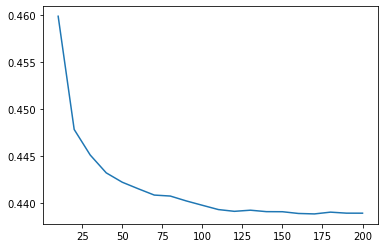

In [50]:
if False: #True:  it took some minutes to run, %%timeit
    scores = []
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n, random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared = False)    
        scores.append((n, rmse))
    
    df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])
    plt.plot(df_scores.n_estimators, df_scores.rmse)

At about `n_estimators = 120` the RMSE stop improving.

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`

In [12]:
if False: # it took some minutes to run, %%timeit
    scores = []

    for d in [10, 15, 20, 25]:
        for n in range(10, 201, 10):
            rf = RandomForestRegressor(n_estimators=n,
                                        max_depth=d,
                                        random_state=1)
            rf.fit(X_train, y_train)

            y_pred = rf.predict(X_val)
            rmse = mean_squared_error(y_val, y_pred, squared = False)

            scores.append((d, n, rmse))

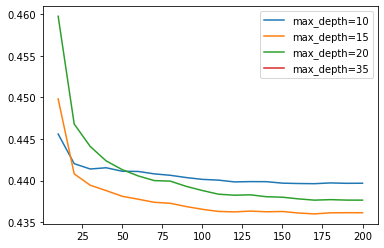

In [13]:
if False:
    columns = ['max_depth', 'n_estimators', 'rmse']
    df_scores = pd.DataFrame(scores, columns=columns)

    for d in [10, 15, 20, 35]:
        df_subset = df_scores[df_scores.max_depth == d]    
        plt.plot(df_subset.n_estimators, df_subset.rmse,
                 label='max_depth=%d' % d)
    plt.legend()

The best `max_depth`is 15. The answer is the same if we change the seed for the model.

## Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doing it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the important features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model

In [14]:
rf = RandomForestRegressor(n_estimators= 10, 
                           max_depth= 20,
                           random_state=1,
                           n_jobs = -1)
rf.fit(X_train, y_train)

rf.feature_importances_

# The higher, the more important the feature. The importance of a feature is computed as the (normalized) total
# reduction of the criterion brought by that feature. It is also known as the Gini importance.

array([7.65657560e-02, 3.02638819e-02, 1.51755500e-01, 1.53475601e-01,
       5.31695975e-02, 4.47273475e-04, 1.11450114e-03, 3.40436593e-02,
       1.03414350e-03, 8.37127171e-05, 4.25185232e-02, 5.45945765e-02,
       3.91898023e-01, 4.87707077e-03, 4.15817992e-03])

In [37]:
list(zip(dv.get_feature_names(),rf.feature_importances_))

[('availability_365', 0.07656575602038891),
 ('calculated_host_listings_count', 0.030263881888999422),
 ('latitude', 0.15175550002877586),
 ('longitude', 0.15347560060953339),
 ('minimum_nights', 0.05316959753835208),
 ('neighbourhood_group=Bronx', 0.0004472734749035815),
 ('neighbourhood_group=Brooklyn', 0.0011145011423147665),
 ('neighbourhood_group=Manhattan', 0.034043659332215426),
 ('neighbourhood_group=Queens', 0.001034143501453153),
 ('neighbourhood_group=Staten Island', 8.371271708698621e-05),
 ('number_of_reviews', 0.042518523151637094),
 ('reviews_per_month', 0.05459457652195896),
 ('room_type=Entire home/apt', 0.3918980233885284),
 ('room_type=Private room', 0.004877070765213998),
 ('room_type=Shared room', 0.004158179918638004)]

In [24]:
max(rf.feature_importances_)

0.3918980233885284

The most important feature is `room_type=Entire home/apt`, as in Question 1.

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

In [40]:
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [41]:
# performance monitoring: after each iteraction, after each new tree is trained, we inmediatly evaluate on the val dataset 
watchlist = [(dtrain, 'train'), (dval, 'val')]  # list of tuples with the dataset and the name we want to put it
# we put it in the "evals" tag when training the model

In [46]:
xgb_params = {
    'eta': 0.3, # learning rate, if 1, the whole new tree substitute the previous tree for the next step
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}
# train the XGB
model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                verbose_eval=5, # we print the evaluation every 5 trees/iterations
                evals=watchlist)
# apply to val
y_pred = model.predict(dval)
# we are overfitting from .. on

[0]	train-rmse:3.02752	val-rmse:3.02415
[5]	train-rmse:0.67490	val-rmse:0.67752
[10]	train-rmse:0.43912	val-rmse:0.44981
[15]	train-rmse:0.42259	val-rmse:0.43827
[20]	train-rmse:0.41716	val-rmse:0.43691
[25]	train-rmse:0.41365	val-rmse:0.43621
[30]	train-rmse:0.40712	val-rmse:0.43543
[35]	train-rmse:0.40444	val-rmse:0.43510
[40]	train-rmse:0.40103	val-rmse:0.43466
[45]	train-rmse:0.39723	val-rmse:0.43371
[50]	train-rmse:0.39446	val-rmse:0.43384
[55]	train-rmse:0.39129	val-rmse:0.43378
[60]	train-rmse:0.38743	val-rmse:0.43404
[65]	train-rmse:0.38421	val-rmse:0.43450
[70]	train-rmse:0.38117	val-rmse:0.43467
[75]	train-rmse:0.37801	val-rmse:0.43489
[80]	train-rmse:0.37668	val-rmse:0.43526
[85]	train-rmse:0.37259	val-rmse:0.43537
[90]	train-rmse:0.36998	val-rmse:0.43539
[95]	train-rmse:0.36742	val-rmse:0.43579
[99]	train-rmse:0.36478	val-rmse:0.43621


Now change `eta` first to `0.1` and then to `0.01`

In [47]:
xgb_params = {
    'eta': 0.1, # learning rate, if 1, the whole new tree substitute the previous tree for the next step
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}
# train the XGB
model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                verbose_eval=5, # we print the evaluation every 5 trees/iterations
                evals=watchlist)
# apply to val
y_pred = model.predict(dval)
# we are overfitting from .. on

[0]	train-rmse:3.87217	val-rmse:3.86889
[5]	train-rmse:2.31905	val-rmse:2.31692
[10]	train-rmse:1.41910	val-rmse:1.41786
[15]	train-rmse:0.91299	val-rmse:0.91348
[20]	train-rmse:0.64528	val-rmse:0.64883
[25]	train-rmse:0.51733	val-rmse:0.52364
[30]	train-rmse:0.46186	val-rmse:0.47101
[35]	train-rmse:0.43843	val-rmse:0.44997
[40]	train-rmse:0.42770	val-rmse:0.44150
[45]	train-rmse:0.42222	val-rmse:0.43795
[50]	train-rmse:0.41868	val-rmse:0.43589
[55]	train-rmse:0.41644	val-rmse:0.43515
[60]	train-rmse:0.41432	val-rmse:0.43460
[65]	train-rmse:0.41226	val-rmse:0.43400
[70]	train-rmse:0.41059	val-rmse:0.43361
[75]	train-rmse:0.40876	val-rmse:0.43336
[80]	train-rmse:0.40747	val-rmse:0.43306
[85]	train-rmse:0.40626	val-rmse:0.43299
[90]	train-rmse:0.40478	val-rmse:0.43280
[95]	train-rmse:0.40406	val-rmse:0.43272
[99]	train-rmse:0.40277	val-rmse:0.43250


In [48]:
xgb_params = {
    'eta': 0.01, # learning rate, if 1, the whole new tree substitute the previous tree for the next step
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}
# train the XGB
model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                verbose_eval=5, # we print the evaluation every 5 trees/iterations
                evals=watchlist)
# apply to val
y_pred = model.predict(dval)
# we are overfitting from .. on

[0]	train-rmse:4.25336	val-rmse:4.25010
[5]	train-rmse:4.04779	val-rmse:4.04454
[10]	train-rmse:3.85242	val-rmse:3.84921
[15]	train-rmse:3.66674	val-rmse:3.66359
[20]	train-rmse:3.49030	val-rmse:3.48719
[25]	train-rmse:3.32263	val-rmse:3.31956
[30]	train-rmse:3.16332	val-rmse:3.16029
[35]	train-rmse:3.01196	val-rmse:3.00898
[40]	train-rmse:2.86817	val-rmse:2.86533
[45]	train-rmse:2.73158	val-rmse:2.72884
[50]	train-rmse:2.60185	val-rmse:2.59925
[55]	train-rmse:2.47865	val-rmse:2.47612
[60]	train-rmse:2.36167	val-rmse:2.35927
[65]	train-rmse:2.25061	val-rmse:2.24835
[70]	train-rmse:2.14519	val-rmse:2.14303
[75]	train-rmse:2.04514	val-rmse:2.04311
[80]	train-rmse:1.95022	val-rmse:1.94827
[85]	train-rmse:1.86015	val-rmse:1.85833
[90]	train-rmse:1.77472	val-rmse:1.77302
[95]	train-rmse:1.69373	val-rmse:1.69214
[99]	train-rmse:1.63198	val-rmse:1.63045


Eta = 0.1 leads to the best RMSE score on the validation dataset.